# **stock Stock Moving Average Cross Strategy**

In [6]:
!pip install ta

In [7]:
import warnings
warnings.filterwarnings("ignore")

import ta
import scipy
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from math import sqrt
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
start_date = datetime(2017,1,1)
end_date = datetime.today()

stock = yf.download('TSLA', start_date , end_date)
stock.reset_index(inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [9]:
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...,...
1697,2023-10-02,244.809998,254.279999,242.619995,251.600006,251.600006,123810400
1698,2023-10-03,248.610001,250.020004,244.449997,246.529999,246.529999,101985300
1699,2023-10-04,248.139999,261.859985,247.600006,261.160004,261.160004,129721600
1700,2023-10-05,260.000000,263.600006,256.250000,260.049988,260.049988,119159200


In [10]:
# Calculate additional features
stock["SMA_20"] = ta.trend.sma_indicator(stock["Close"], window = 20, fillna = True)
stock["SMA_50"] = ta.trend.sma_indicator(stock["Close"], window = 50, fillna = True)
stock["SMA_10"] = ta.trend.sma_indicator(stock["Close"], window = 10, fillna = True)
stock["SMA_30"] = ta.trend.sma_indicator(stock["Close"], window = 30, fillna = True)

stock["EMA_12"] = ta.trend.ema_indicator(stock["Close"], window = 12, fillna = True)
stock["EMA_26"] = ta.trend.ema_indicator(stock["Close"], window = 26, fillna = True)
stock["EMA_40"] = ta.trend.ema_indicator(stock["Close"], window = 40, fillna = True)
stock["EMA_60"] = ta.trend.ema_indicator(stock["Close"], window = 60, fillna = True)

stock["MACD"] = ta.trend.macd(stock["Close"], fillna = True)
stock["RSI"] = ta.momentum.rsi(stock["Close"], fillna = True)

In [11]:
stock

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,SMA_30,EMA_12,EMA_26,EMA_40,EMA_60,MACD,RSI
0,2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500,14.466000,14.466000,14.466000,14.466000,14.466000,14.466000,14.466000,14.466000,0.000000,100.000000
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,14.799333,14.799333,14.799333,14.799333,14.568564,14.515382,14.498520,14.487858,0.053181,100.000000
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,14.905111,14.905111,14.905111,14.905111,14.652887,14.559922,14.528673,14.508474,0.092965,97.480537
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,14.995667,14.995667,14.995667,14.995667,14.747417,14.612323,14.564706,14.533355,0.135095,97.993262
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,15.080267,15.080267,15.080267,15.080267,14.850687,14.672052,14.606362,14.562381,0.178635,98.355310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,2023-10-02,244.809998,254.279999,242.619995,251.600006,251.600006,123810400,257.297501,251.057800,250.948001,252.396666,251.750988,252.827811,252.085162,249.083012,-1.076823,49.117057
1698,2023-10-03,248.610001,250.020004,244.449997,246.529999,246.529999,101985300,256.799501,250.607200,248.951001,252.904999,250.947759,252.361307,251.814178,248.999307,-1.413547,45.742195
1699,2023-10-04,248.139999,261.859985,247.600006,261.160004,261.160004,129721600,257.261501,250.524800,248.808002,253.837333,252.518874,253.013062,252.270072,249.398018,-0.494188,55.289011
1700,2023-10-05,260.000000,263.600006,256.250000,260.049988,260.049988,119159200,257.689500,250.438800,249.243001,254.610332,253.677507,253.534316,252.649580,249.747263,0.143191,54.505391


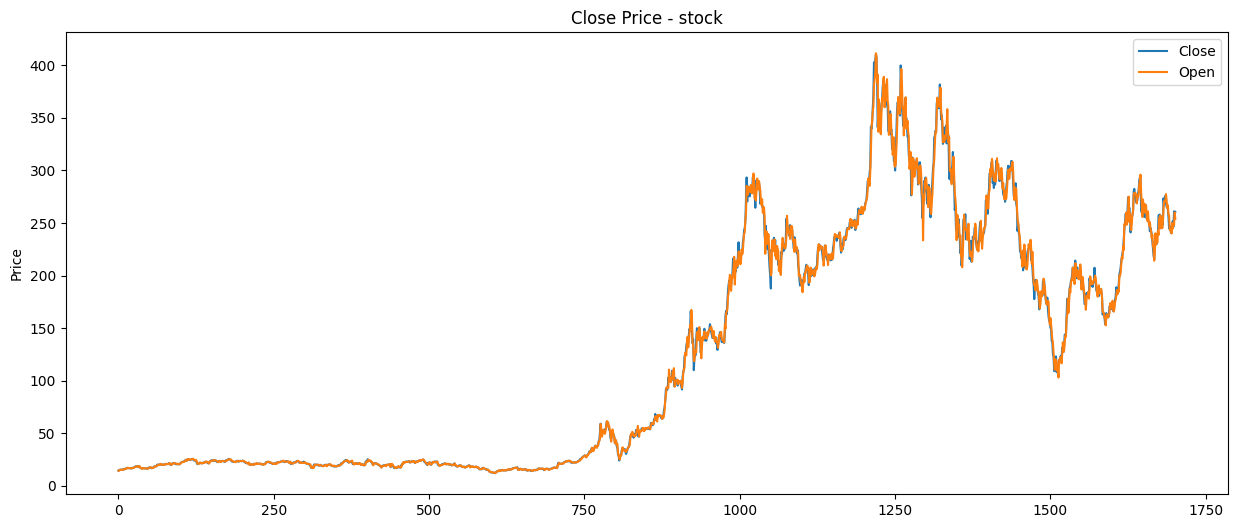

In [12]:
stock[['Close', 'Open']].plot(figsize=(15,6))
plt.title('Close Price - stock')
plt.ylabel('Price')
plt.show()

import plotly.express as px
fig = px.line(stock, x='Date', y=['Close', 'Open'])
fig.show()

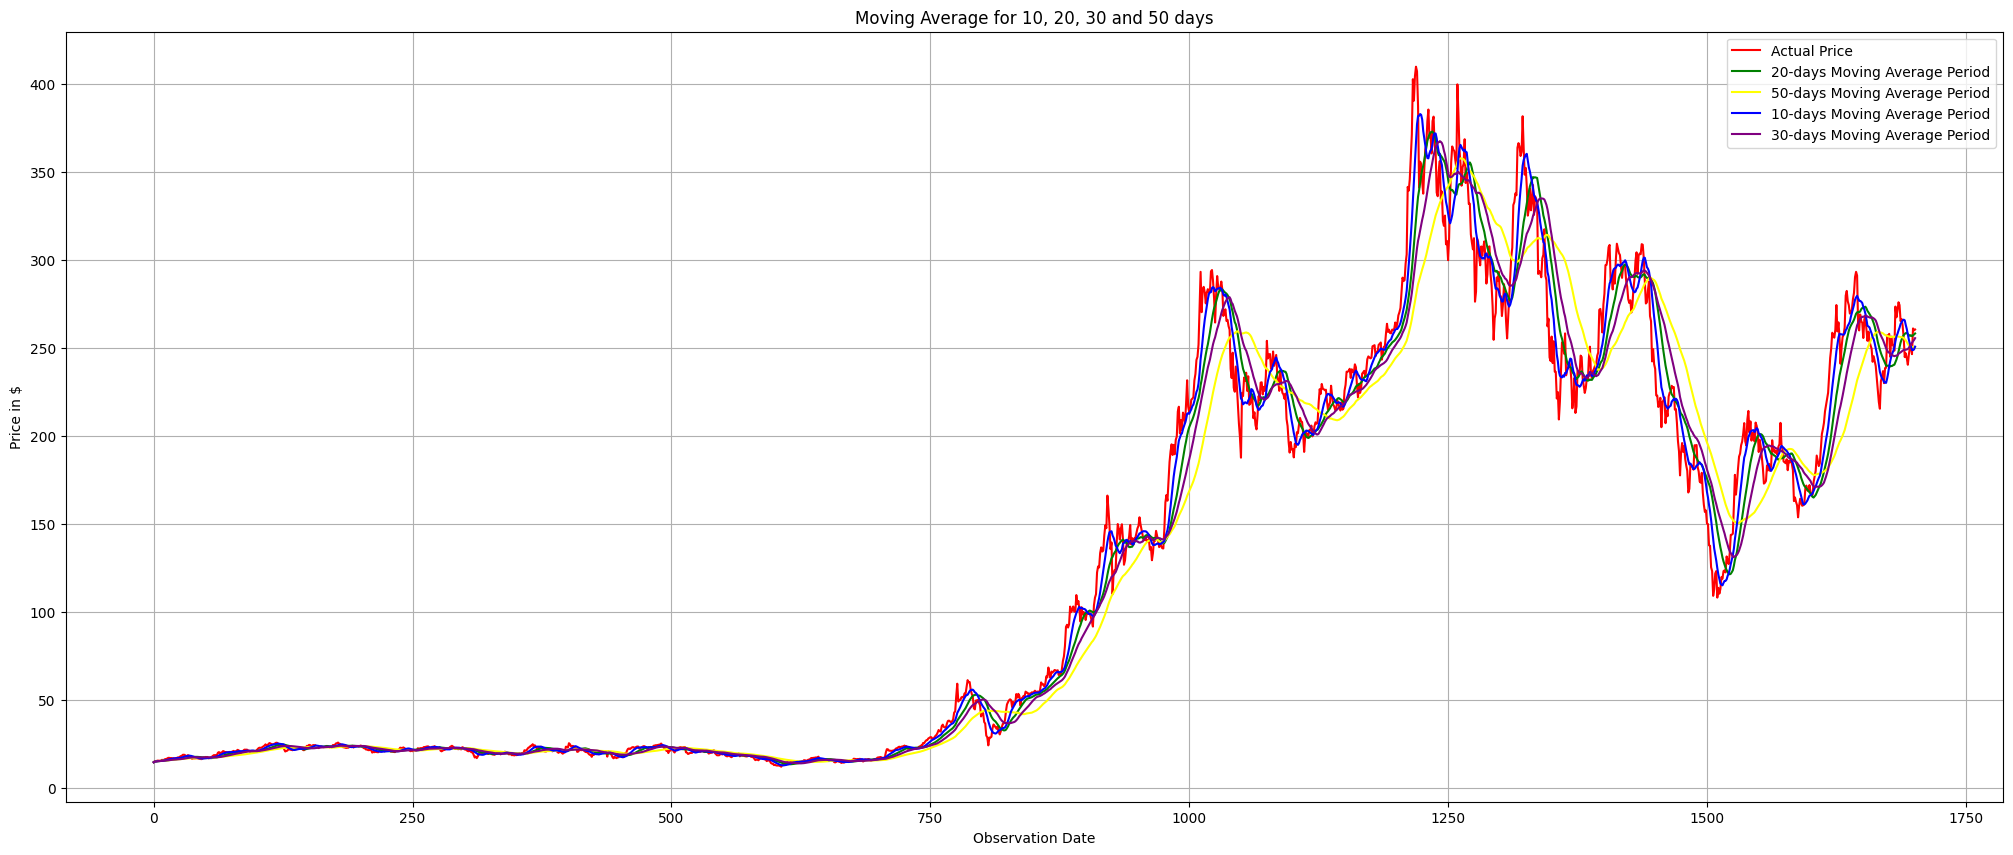

NameError: name 'done' is not defined

In [13]:
fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
stock['Close'].plot(label='Actual Price', color = 'red')
stock['SMA_20'].plot(label = '20-days Moving Average Period', color = 'green')
stock['SMA_50'].plot(label = '50-days Moving Average Period', color = 'yellow')
stock['SMA_10'].plot(label = '10-days Moving Average Period', color = 'blue')
stock['SMA_30'].plot(label = '30-days Moving Average Period', color = 'purple')

plt.ylabel('Price in $')
plt.xlabel('Observation Date')
plt.title('Moving Average for 10, 20, 30 and 50 days')
plt.legend()
plt.grid()
plt.show()

fig.savefig('SMA_Plot.png')



In [14]:
import plotly.express as px
fig = px.line(stock, x='Date', y=['Close','SMA_20', 'SMA_50', 'SMA_10', 'SMA_30'])
fig.show()

In [15]:
'''fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
stock['Close'].plot(label='Actual Price', color = 'red')
stock['EMA_12'].plot(label = '12-days EMA Span', color = 'green')
stock['EMA_26'].plot(label = '26-days EMA Span', color = 'yellow')
stock['EMA_40'].plot(label = '40-days EMA Span', color = 'blue')
stock['EMA_60'].plot(label = '60-days EMA Span', color = 'purple')

plt.ylabel('Price in $')
plt.xlabel('Observation Date')
plt.title('EMA Span for 12, 26, 40 and 60 days')
plt.legend()
plt.grid()
plt.show()

fig.savefig('EMA_Plot.png')
'''
import plotly.express as px
fig = px.line(stock, x='Date', y=['Close','EMA_12', 'EMA_26', 'EMA_40', 'EMA_60'])
fig.show()

In [16]:
stock['SMA_Signal'] = 0.0
stock['SMA_Signal'] = np.where(stock['SMA_20'] > stock['SMA_50'], 1.0, 0.0)

stock['SMA_Position'] = stock['SMA_Signal'].diff()
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,SMA_30,EMA_12,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position
0,2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500,14.466000,14.466000,14.466000,14.466000,14.466000,14.466000,14.466000,14.466000,0.000000,100.000000,0.0,NaN
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,14.799333,14.799333,14.799333,14.799333,14.568564,14.515382,14.498520,14.487858,0.053181,100.000000,0.0,0.0
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,14.905111,14.905111,14.905111,14.905111,14.652887,14.559922,14.528673,14.508474,0.092965,97.480537,0.0,0.0
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,14.995667,14.995667,14.995667,14.995667,14.747417,14.612323,14.564706,14.533355,0.135095,97.993262,0.0,0.0
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,15.080267,15.080267,15.080267,15.080267,14.850687,14.672052,14.606362,14.562381,0.178635,98.355310,0.0,0.0


In [36]:
'''fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
stock['Close'].plot(color = 'k', label= 'Close')
stock['SMA_20'].plot(color = 'b',label = '20-day SMA')
stock['SMA_50'].plot(color = 'y',label = '50-day SMA')

# plot ‘buy’ signals
plt.plot(stock[stock['SMA_Position'] == 1].index,
         stock['SMA_20'][stock['SMA_Position'] == 1],
         '^', markersize = 15, color = 'g', label = 'buy')

# plot ‘sell’ signals
plt.plot(stock[stock['SMA_Position'] == -1].index,
         stock['SMA_20'][stock['SMA_Position'] == -1],
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('stock - SMA Crossover')
plt.legend()
plt.grid()
plt.show()

fig.savefig('SMA_Crossover_Plot.png')'''

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=stock.index, y=stock['Close'], name='Close'))
fig.add_trace(go.Scatter(x=stock.index, y=stock['SMA_20'], name='20-day SMA'))
fig.add_trace(go.Scatter(x=stock.index, y=stock['SMA_50'], name='50-day SMA'))

fig.add_trace(go.Scatter(
    x=stock[stock['SMA_Position'] == 1].index, 
    y=stock['SMA_20'][stock['SMA_Position'] == 1],
    mode='markers',
    marker=dict(color='green', symbol='triangle-up'),
    name='buy'
))

fig.add_trace(go.Scatter(
    x=stock[stock['SMA_Position'] == -1].index,
    y=stock['SMA_20'][stock['SMA_Position'] == -1], 
    mode='markers',
    marker=dict(color='red', symbol='triangle-down'),
    name='sell'
))

fig.update_layout(
    title='stock - SMA Crossover',
    xaxis_title='Date',
    yaxis_title='Price in $',
    legend_title='Legend',
)

fig.show()

In [22]:
# Create a new column 'Signal' such that if 12-day EMA is greater than 26-day EMA then set Signal as 1 else 0
stock['EMA_Signal'] = 0.0
stock['EMA_Signal'] = np.where(stock['EMA_12'] > stock['EMA_26'], 1.0, 0.0)
stock['EMA_Position'] = stock['EMA_Signal'].diff()

In [23]:
'''fig = plt.figure(figsize = (25,10))

stock['Close'].plot(color = 'k', lw = 1, label = 'Close Price')
stock['EMA_12'].plot(color = 'b', lw = 1, label = '12-day EMA')
stock['EMA_26'].plot(color = 'g', lw = 1, label = '26-day EMA')

plt.plot(stock[stock['EMA_Position'] == 1].index,
         stock['EMA_12'][stock['EMA_Position'] == 1],
         '^', markersize = 10, color = 'g', label = 'buy')

plt.plot(stock[stock['EMA_Position'] == -1].index,
         stock['EMA_12'][stock['EMA_Position'] == -1],
         'v', markersize = 10, color = 'r', label = 'sell')

plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('stock - EMA Crossover')
plt.legend()
plt.grid()
plt.show()

fig.savefig('EMA_Crossover_Plot.png')'''
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=stock['Date'], y=stock['Close'], name='Close'))
fig.add_trace(go.Scatter(x=stock['Date'], y=stock['EMA_12'], name='12-day EMA'))
fig.add_trace(go.Scatter(x=stock['Date'], y=stock['EMA_26'], name='26-day EMA'))

fig.add_trace(go.Scatter(
    x=stock[stock['EMA_Position'] == 1].index, 
    y=stock['EMA_12'][stock['EMA_Position'] == 1],
    mode='markers',
    marker=dict(color='green', symbol='triangle-up'),
    name='buy'
))

fig.add_trace(go.Scatter(
    x=stock[stock['EMA_Position'] == -1].index,
    y=stock['EMA_12'][stock['EMA_Position'] == -1], 
    mode='markers',
    marker=dict(color='red', symbol='triangle-down'),
    name='sell'
))

fig.update_layout(
    title='stock - EMA Crossover',
    xaxis_title='Date',
    yaxis_title='Price in $',
    legend_title='Legend',
)

fig.show()

In [24]:
rmse = sqrt(mean_squared_error(stock['Close'], stock['EMA_12']))
rmse

10.486187134447025

In [25]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [26]:
x = stock['Close'].tolist()
y = stock['EMA_12'].tolist()

rsquared(x, y)

0.99157483693034

In [27]:
for index, row in stock.iterrows():
    if stock.loc[index,'Close'] > stock.loc[index,'EMA_12']:
        stock.loc[index,'EMA_12_Signal'] = 1
    elif stock.loc[index,'Close'] < stock.loc[index,'EMA_12']:
        stock.loc[index,'EMA_12_Signal'] = -1
    else:
        stock.loc[index,'EMA_12_Signal'] = 0

In [28]:
stock.dropna(axis=0,how='any',inplace=True)
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,...,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position,EMA_Signal,EMA_Position,EMA_12_Signal
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,14.799333,14.799333,14.799333,...,14.515382,14.498520,14.487858,0.053181,100.000000,0.0,0.0,1.0,1.0,1.0
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,14.905111,14.905111,14.905111,...,14.559922,14.528673,14.508474,0.092965,97.480537,0.0,0.0,1.0,0.0,1.0
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,14.995667,14.995667,14.995667,...,14.612323,14.564706,14.533355,0.135095,97.993262,0.0,0.0,1.0,0.0,1.0
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,15.080267,15.080267,15.080267,...,14.672052,14.606362,14.562381,0.178635,98.355310,0.0,0.0,1.0,0.0,1.0
5,2017-01-10,15.466667,15.466667,15.126000,15.324667,15.324667,54900000,15.121000,15.121000,15.121000,...,14.720394,14.641402,14.587374,0.203213,87.763614,0.0,0.0,1.0,0.0,1.0


In [29]:
stock['EMA_12_Signal']= stock['EMA_12_Signal'].shift(1)
stock

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,...,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position,EMA_Signal,EMA_Position,EMA_12_Signal
1,2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,14.799333,14.799333,14.799333,...,14.515382,14.498520,14.487858,0.053181,100.000000,0.0,0.0,1.0,1.0,NaN
2,2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,14.905111,14.905111,14.905111,...,14.559922,14.528673,14.508474,0.092965,97.480537,0.0,0.0,1.0,0.0,1.0
3,2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,14.995667,14.995667,14.995667,...,14.612323,14.564706,14.533355,0.135095,97.993262,0.0,0.0,1.0,0.0,1.0
4,2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,15.080267,15.080267,15.080267,...,14.672052,14.606362,14.562381,0.178635,98.355310,0.0,0.0,1.0,0.0,1.0
5,2017-01-10,15.466667,15.466667,15.126000,15.324667,15.324667,54900000,15.121000,15.121000,15.121000,...,14.720394,14.641402,14.587374,0.203213,87.763614,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,2023-10-02,244.809998,254.279999,242.619995,251.600006,251.600006,123810400,257.297501,251.057800,250.948001,...,252.827811,252.085162,249.083012,-1.076823,49.117057,1.0,0.0,0.0,0.0,-1.0
1698,2023-10-03,248.610001,250.020004,244.449997,246.529999,246.529999,101985300,256.799501,250.607200,248.951001,...,252.361307,251.814178,248.999307,-1.413547,45.742195,1.0,0.0,0.0,0.0,-1.0
1699,2023-10-04,248.139999,261.859985,247.600006,261.160004,261.160004,129721600,257.261501,250.524800,248.808002,...,253.013062,252.270072,249.398018,-0.494188,55.289011,1.0,0.0,0.0,0.0,-1.0
1700,2023-10-05,260.000000,263.600006,256.250000,260.049988,260.049988,119159200,257.689500,250.438800,249.243001,...,253.534316,252.649580,249.747263,0.143191,54.505391,1.0,0.0,1.0,1.0,1.0


In [30]:
stock['EMA_12_Signal'].value_counts()

EMA_12_Signal
 1.0    955
-1.0    745
Name: count, dtype: int64

In [31]:
initial_amt = 30000
total_shares = 30
initial_accountbalance = initial_amt
initial_shares = total_shares

print('Account balance ',initial_amt)
print('Initial number of shares owned ',total_shares)
ini_price = stock.loc[1,'Close']
avg_price = stock['Close'].mean()
initial_val = initial_amt + ini_price*total_shares
#initial amount+total_shares*ini_price

for index, row in stock.iterrows():
    if stock.loc[index,'EMA_12_Signal'] == 1:
        if (initial_amt - stock.loc[index,'Close'])> 0 :
            initial_amt -= stock.loc[index,'Close']
            avg_price = ((avg_price*total_shares)+stock.loc[index,'Close'])/(total_shares+1)
            total_shares = total_shares + 1;
            stock.loc[index,'Action'] = "Buy"
        else:
            stock.loc[index,'Action'] = "Buy Alert"
    elif stock.loc[index,'EMA_12_Signal'] == -1:
        if total_shares - 1 > 0 :
            stock.loc[index,'Action'] = "Sell"
            avg_price = ((avg_price*total_shares)-stock.loc[index,'Close'])/(total_shares-1)
            initial_amt += stock.loc[index,'Close'];
            total_shares = total_shares - 1;
        else:
            stock.loc[index,'Action'] = "Sell Alert"
    else:
        stock.loc[index,'Action'] = "Hold"

print('----------------Signals Given During Day To Day Trade------------------------')
print(stock.tail(10))
print('----------------Results-------------------------')
print('Balance left in Account',initial_amt)
print('Total Number of shares ',total_shares)
final_amt = initial_amt

Account balance  30000
Initial number of shares owned  30
----------------Signals Given During Day To Day Trade------------------------
           Date        Open        High         Low       Close   Adj Close  \
1692 2023-09-25  243.380005  247.100006  238.309998  246.990005  246.990005   
1693 2023-09-26  242.979996  249.550003  241.660004  244.119995  244.119995   
1694 2023-09-27  244.259995  245.330002  234.580002  240.500000  240.500000   
1695 2023-09-28  240.020004  247.550003  238.649994  246.380005  246.380005   
1696 2023-09-29  250.000000  254.770004  246.350006  250.220001  250.220001   
1697 2023-10-02  244.809998  254.279999  242.619995  251.600006  251.600006   
1698 2023-10-03  248.610001  250.020004  244.449997  246.529999  246.529999   
1699 2023-10-04  248.139999  261.859985  247.600006  261.160004  261.160004   
1700 2023-10-05  260.000000  263.600006  256.250000  260.049988  260.049988   
1701 2023-10-06  253.979996  261.649994  250.649994  260.529999  260.52999

In [32]:
# Profit calculation
inital_share_worth = initial_shares * stock.loc[min(stock.index),'Close'] + initial_accountbalance

final_shares = total_shares
final_share_worth = final_shares * stock.loc[max(stock.index),'Close'] + final_amt

profit_percent = (final_share_worth - inital_share_worth)/inital_share_worth
print('Profit gained: ', profit_percent*100, '%')

Profit gained:  125.81507769122129 %


In [34]:
'''fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17,10))

ax1.plot(stock['Close'], label='Actual Price', color = 'red')
ax1.plot(stock['EMA_12'], label = '12 Days EMA Span', color = 'green')
ax1.set_title('12 Days Span EMA with Trading Position')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')

ax2.plot(stock['EMA_12_Signal'], label='Trading position')
ax2.set_title('Trading Signal')
ax2.set_xlabel('Date')
ax2.set_ylabel('Trading position')

fig.savefig('Trading_Strategy.png')'''

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.05)

fig.add_trace(go.Scatter(
    x=stock.index, 
    y=stock['Close'], 
    name='Actual Price',
    marker_color='red'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=stock.index, 
    y=stock['EMA_12'],
    name='12 Days EMA Span',
    marker_color='green'
), row=1, col=1)

fig.update_yaxes(title_text="Price in $", row=1, col=1)

fig.add_trace(go.Scatter(
    x=stock.index, 
    y=stock['EMA_12_Signal'], 
    name='Trading position'
), row=2, col=1) 

fig.update_yaxes(title_text="Trading position", row=2, col=1)

fig.update_xaxes(title_text="Date", row=2, col=1)

fig.update_layout(
    title_text="12 Days Span EMA with Trading Position", 
    height=600
)

fig.show()